#  <font color='blue'>2019 Ford GoBike ride share data analysis</font>
#### By Kavita Kamble

## <font color='blue'>2019 Ford GoBike Investigation Overview</font>

> Using the twelve months data for 2019, we want to investigate following questions:
> How is the behavior of subscribers & customers when it comes to trip usage and trip duration?
> Which months have higher trip usage and what month is the higher demand for more bikes?
> Do members and non menbers differ when it comes to trip usage & trip duration?
> What is the relation between day of the week, hour of the day and user type?

## <font color='blue'>2019 Ford GoBike Dataset Overview</font>

> The Data consists of information about Bay Wheels GoBike trips for year 2019: There are 2506983 rows of trip data and 19 columns. The data provides three type of information for each trip. Duration of the trip -- duration_sec, start_time, end_time Station information -- start_station_id, start_station_latitude, start_station_longitude, end_station_id, end_station_latitude, end_station_longitude rider's information -- user_type, bike_share_for_all_trip, rental_access_method.

In [1]:
# import all packages and set plots to be embedded inline
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import glob
%matplotlib inline
import matplotlib.ticker as tick
from pandas.api.types import CategoricalDtype

# suppress warnings from final output
import warnings
warnings.simplefilter("ignore")

In [2]:
# load in the dataset into a pandas dataframe
# Read the data from masterdata.csv into pandas dataframe
df = pd.read_csv('masterdata.csv',low_memory=False)

In [3]:
fordtrips = df.copy()
fordtrips.drop(['Unnamed: 0','end_station_name','start_station_name'], axis = 1, inplace=True)
fordtrips['end_time'] = pd.to_datetime(fordtrips['end_time'])
fordtrips['start_time'] = pd.to_datetime(fordtrips['start_time'])
fordtrips['start_station_id'] = fordtrips['start_station_id'].astype('str')
fordtrips['end_station_id'] = fordtrips['end_station_id'].astype('str')
fordtrips['bike_id'] = fordtrips['bike_id'].astype('str')
fordtrips['user_type'] = fordtrips['user_type'].astype('category')
fordtrips['duration_minute'] = fordtrips['duration_sec']/60
fordtrips['start_date'] = fordtrips.start_time.dt.strftime('%Y-%m-%d')
fordtrips['start_hourofday'] = fordtrips.start_time.dt.strftime('%H')
fordtrips['start_dayofweek'] = fordtrips.start_time.dt.strftime('%A')
fordtrips['start_month'] = fordtrips.start_time.dt.strftime('%B')
fordtrips['start_day'] = fordtrips.start_time.dt.strftime('%d')
weekday = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
weekday_category = pd.api.types.CategoricalDtype(categories=weekday, ordered=True)
fordtrips['start_dayofweek'] = fordtrips['start_dayofweek'].astype(weekday_category)
months = ['January','February','March','April','May','June','July','August','September','October','November','December']
months_category = pd.api.types.CategoricalDtype(categories=months, ordered=True)
fordtrips['start_month'] = fordtrips['start_month'].astype(months_category)


In [4]:
fordtrips = fordtrips.query('duration_minute <= 69')

### <font color='blue'>Ford GoBike trip usage and duration for subscribers and customers</font>

> Overall subscriber trip usage is 81.2% in comparison with customer trip usage at 18.8%. The distribution of trip usage over months shows gradual increase from January to December for customers, while subscribers show higher usage during March, April, July and October. There is a drastic dip in the subscriber's trip usage in the winter months November and December.

> Trip duration seem to fall heavily under 0-15 minutes for both subscribers and customers.

In [5]:
def transform_axis(dailyBike, pos):
    if dailyBike >= 1000:
        value = int(dailyBike/1000)
        return '{:d}K'.format(value)
    elif dailyBike >= 1000000: 
        value = int(dailyBike/1000000)
        return '{:d}M'.format(value)
    else:
        return int(dailyBike)

In [6]:
# Number of rides per month for customers and subscribers
user_rides = fordtrips.groupby(['start_month','user_type']).size().reset_index()

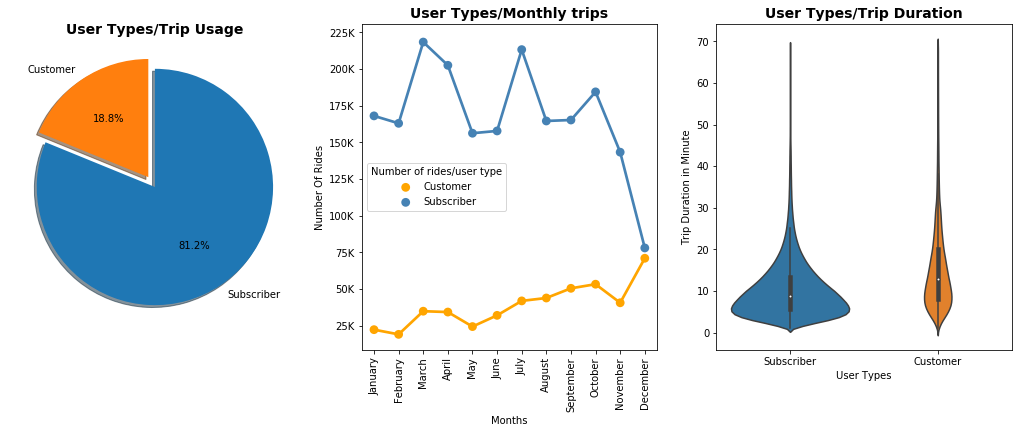

In [7]:
plt.figure(figsize=[18, 6]);

# Plot user_type and yearly trip usage
plt.subplot(1, 3, 1);
sorted_vals = fordtrips.user_type.value_counts()/fordtrips.shape[0];
plt.pie(sorted_vals, explode=[0, 0.1], labels=sorted_vals.index, startangle=90, counterclock=False, autopct='%1.1f%%', shadow=True);
plt.title('User Types/Trip Usage', fontsize=14, fontweight='semibold');

# Plot user_type and monthly trip usage
plt.subplot(1, 3, 2);
palette={'Subscriber':'steelblue', 'Customer':'Orange'};
ax = sb.pointplot(data=user_rides, x='start_month', y=0, hue='user_type', palette=palette);
ax.legend(title='Number of rides/user type');
axis = plt.gca();
axis.yaxis.set_major_formatter(tick.FuncFormatter(transform_axis));
plt.xticks(rotation=90);
plt.xlabel('Months');
plt.ylabel('Number Of Rides');
plt.title('User Types/Monthly trips', fontsize=14, fontweight='semibold');

# Plot user_type and duration_minute
plt.subplot(1, 3, 3);
sb.violinplot(data=fordtrips, x='user_type', y='duration_minute',  order=["Subscriber", "Customer"], scale='count');
plt.xlabel('User Types');
plt.ylabel('Trip Duration in Minute');
plt.title('User Types/Trip Duration', fontsize=14, fontweight='semibold');


###  <font color='blue'>Ford GoBike overall trip usage vs unique bike usage across months</font>

> Overall, number of trips across 12 months show hogher usage in March, April, July and Octomer close to 250000 rides in a month. Number of unique bikes usage show heavy usage in the months May, June and July. Summer months seem to have more unique bikes used undersatndably because more people are out renting out the bikes.
> November to February shows lowest overall usage as well as unique bikes being used as these are winter months.

In [8]:
#Average count of rides per bike per day
count_rides = fordtrips.groupby('start_month')['bike_id'].size().reset_index()
count_unique_rides = fordtrips.groupby('start_month')['bike_id'].nunique().reset_index().rename(columns={'bike_id':'unique_bike_id'})
count_rides_dataFrame = count_rides.merge(count_unique_rides, on='start_month')
count_rides_dataFrame['number_of_unique_bikes_used'] = count_rides_dataFrame['bike_id']/count_rides_dataFrame['unique_bike_id']

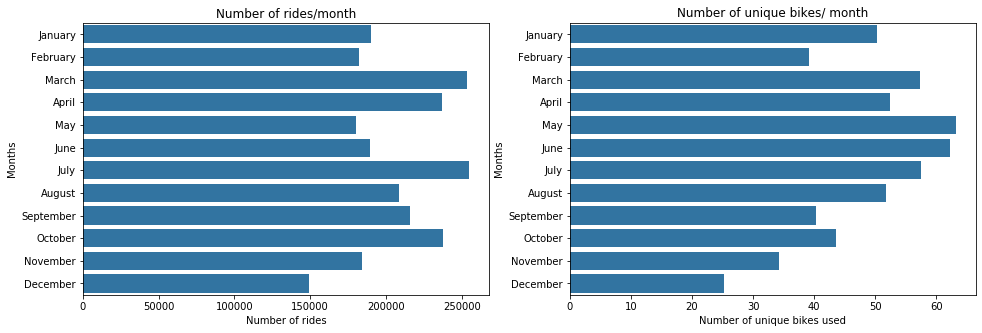

In [9]:
plt.figure(figsize=(16,5))
# Plot overall bike share ride count for all the months of 2019
plt.subplot(1, 2, 1);
base_color = sb.color_palette()[0]
sb.countplot(data=fordtrips, y = 'start_month', color=base_color)
plt.xlabel('Number of rides');
plt.ylabel('Months');
plt.title('Number of rides/month');


# Plot number of bikes used per month
plt.subplot(1, 2, 2);
sb.barplot(data=count_rides_dataFrame, y='start_month', x='number_of_unique_bikes_used', color=base_color);
plt.title('Number of unique bikes/ month');
plt.xlabel('Number of unique bikes used');
plt.ylabel('Months');


### <font color='blue'>Ford GoBike trip usage across months and trip duration for members and non members</font>

> Riders who are member of 'Bike share for all' program are way less in number as compare to non-members. This reflects into their monthly usage. Surprisingly, for both members as well as non-members, summer months doesn't show higher usage, but the month of March and October. Winter months show lower usage as expected.

> For members, almost whole distribution seems to fall between 0-15 minutes as members must be using the rides for a routine trips with fixed duration. Non members seems to have duration distributed over 0-70 minutes, 0-15 minutes being the most common trip time, as casual user must be taking the trips for short to long.

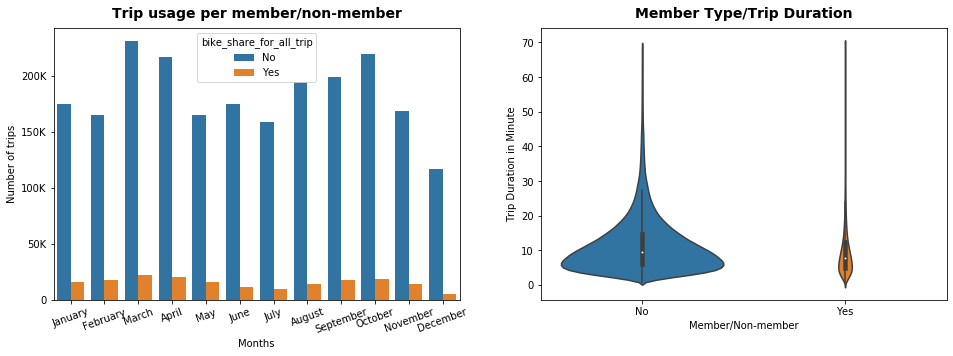

In [10]:
# duration_minute and ride_share_for_all
plt.figure(figsize=(16,5))
plt.subplot(1, 2, 1);
sb.countplot(data=fordtrips, x='start_month', hue='bike_share_for_all_trip')
plt.title('Trip usage per member/non-member', fontsize=14, fontweight='semibold', y=1.015)
plt.xlabel('Months')
plt.ylabel('Number of trips')
axis = plt.gca()
axis.yaxis.set_major_formatter(tick.FuncFormatter(transform_axis))
plt.xticks(rotation=20);

# Plot membertype and duration_minute
plt.subplot(1, 2, 2);
sb.violinplot(data=fordtrips, x='bike_share_for_all_trip', y='duration_minute',  scale="count");
plt.xlabel('Member/Non-member');
plt.ylabel('Trip Duration in Minute');
plt.title('Member Type/Trip Duration', fontsize=14, fontweight='semibold', y=1.015);

### <font color='blue'>Ford GoBike trip usage acoss days and hours for subscribers and customers</font> 

> Subscribers clearly have heavy trip usage during the weekdays rush hours (Monday - Friday, 7am-9am and 4pm-6pm, friday being the slower. Considering these users have subscription and might be using the bike rides for more routine/fix ddistances for example to go to work. Early morning, middle of the day and late night hours as well as weekends have very low usage.
> On the other hand, along with having heavy trip usage during weekday rush hours, customers seems to have good amount of usage on the weekends during daytime hours 9am -8pm as they must be using it for casual bike riding. Early morning and late night hours of the day seems to have low usage as expected. 

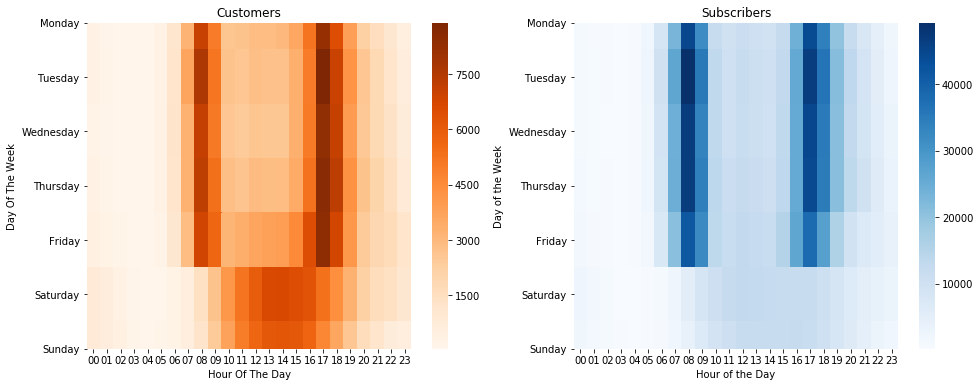

In [11]:
customers = fordtrips.query('user_type=="Customer"')                           
ct_counts = customers.groupby(['start_dayofweek', 'start_hourofday']).size()
ct_counts = ct_counts.reset_index(name='count')
ct_counts = ct_counts.pivot(index = 'start_dayofweek', columns = 'start_hourofday', values = 'count')
subscribers = fordtrips.query('user_type == "Subscriber"')
st_counts = subscribers.groupby(['start_dayofweek', 'start_hourofday']).size()
st_counts = st_counts.reset_index(name='count')
st_counts = st_counts.pivot(index='start_dayofweek', columns='start_hourofday', values='count')

plt.figure(figsize=[16, 6]);
#plot the heatmap
plt.subplot(1, 2, 1)
sb.heatmap(ct_counts, cmap='Oranges');
plt.xlabel('Hour Of The Day');
plt.ylabel('Day Of The Week');
plt.title('Customers');
#plot the heatmap
plt.subplot(1, 2, 2)
sb.heatmap(st_counts, cmap='Blues');
plt.title('Subscribers');
plt.xlabel('Hour of the Day');
plt.ylabel('Day of the Week');


In [ ]:
# Start the slide show presentation

!jupyter nbconvert slide_deck_template.ipynb --to slides --post serve --template output_toggle

# This should open a tab in your web browser where you can scroll through your presentation. 
# Sub-slides can be accessed by pressing 'down' when viewing its parent slide.

[NbConvertApp] Converting notebook slide_deck_template.ipynb to slides
[NbConvertApp] Writing 488464 bytes to slide_deck_template.slides.html
[NbConvertApp] Redirecting reveal.js requests to https://cdnjs.cloudflare.com/ajax/libs/reveal.js/3.5.0
Serving your slides at http://127.0.0.1:8000/slide_deck_template.slides.html
Use Control-C to stop this server
